In [1]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import cv2

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
def load_dir_reduced_to_height(dirname,file_prefix,max_files):
    '''
    
    '''   
    ## Load all filenames in directory
    var_list = []
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))        
    step_size = 100
    for j in tqdm(np.arange(0,max_files,step_size)):
        BDFs = [BDF.BeadDataFile(dirname+filename) for filename in files[j:j+step_size]]
        [var_list.append(BDFs[k].bead_height) for k in range(len(BDFs))]
    return var_list

In [3]:
def load_dir_reduced_to_zfeedback(dirname,file_prefix,max_files):
    '''
    
    '''   
    ## Load all filenames in directory
    var_list = []
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))        
    step_size = 100
    for j in tqdm(np.arange(0,max_files,step_size)):
        BDFs = [BDF.BeadDataFile(dirname+filename) for filename in files[j:j+step_size]]
        [var_list.append(np.mean(BDFs[k].feedback[2])) for k in range(len(BDFs))]
    return var_list


In [4]:
def gaussian(x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+params[3]


In [5]:
def gaussian_bead_pos_fit(img,axis=0,low_x_lim=500,up_x_lim=800,low_y_lim=420,up_y_lim=550,upper_area=300,up_lim_width=20):

    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
    return (chisquarevalue, ndf)

    def gaussian(x,params=list):
        norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+params[3]

    
    def chisquare_gaussian(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
   

    area=0
    mean=0
    sigma=0
    constant=0
    
    if(axis==0):
        img2 = img.transpose()
        data_x = range(1024) # give x data
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_y_lim
        up_lim_mean = up_y_lim
        
    if(axis==1):
        data_x = range(1280) # give x data
        data_y = np.mean(img[low_y_lim:up_y_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_x_lim
        up_lim_mean = up_x_lim
        
        
    m=Minuit(chisquare_gaussian, 
             area = 100, # set start parameter
             error_area = 1,
             limit_area= (0,upper_area), # if you want to limit things
             #fix_area = "True", # you can also fix it
             mean = np.argmax(data_y),
             error_mean = 1,
             #fix_mean = "False",
             limit_mean = (low_lim_mean,up_lim_mean),
             sigma = 15,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant = 10,
             error_constant = 1,
             #fix_constant=0,
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    return m.values['mean']#,m

In [6]:
def load_img_files(path):
    # read in the data 
    files = glob.glob(path)
    img_files = []
    for i in range(0,len(files)):
        img_files.append(cv2.imread(files[i],0))
    print(files) 
    return img_files

In [7]:
Year = "2020"
Month = "02"
Day = "10"
BeadNumber =2
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)
folder_processed = r"/data/new_trap_processed/harmonics_processed/"+ Year + Month + Day + "/Bead"+str(BeadNumber)


In [8]:
dirname = "/data/new_trap/20200210/Bead2/Shaking/Shaking384/"
file_prefix = "Shaking3"

zfeed = load_dir_reduced_to_zfeedback(dirname,file_prefix,50000)

  3%|▎         | 13/500 [00:27<35:47,  4.41s/it]

KeyboardInterrupt: 

In [8]:
def height_analysis_wrapper(dirname,file_prefix):

    maximum_intensity, mean_intensity, sum_intensity, max_bin_2d, max_bin_1d, max_y_1d_zoom,max_z_1d_zoom = ([] for i in range(7))

    pos_y = [] 
    pos_z =[]
    pos_z_alt =[]
    s = time.time()
    
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.npy')]

    for j in tqdm(range(len(files))):
        img = np.load(dirname + "/Shaking%d.npy" %j)
        #img = np.load("/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures/Shaking%d.npy" %j)
        maximum_intensity.append(np.max(img))
        mean_intensity.append(np.mean(img))
        sum_intensity.append(np.sum(img))
        max_bin_2d.append(np.argmax(img))
        max_bin_1d.append(np.argmax(np.mean(img, axis=1)))    
        img2 = img.transpose()
        max_y_1d_zoom.append(np.argmax(np.mean(img[400:500],axis=0)))    
        max_z_1d_zoom.append(np.argmax(np.mean(img2[600:700],axis=0)))    
        pos_z.append(gaussian_bead_pos_fit(img,axis=0))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))
        pos_y.append(gaussian_bead_pos_fit(img,axis=1))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    
        pos_z_alt.append(gaussian_bead_pos_fit(img,axis=0,up_lim_width=10))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    

        #pos.append(gaussian_bead_pos_fit(img2))
    e = time.time()
    print("Time passed %d" %(e-s))                      
    return pos_z,pos_y,pos_z_alt,maximum_intensity, mean_intensity, sum_intensity, max_bin_2d, max_bin_1d, max_y_1d_zoom,max_z_1d_zoom

In [9]:
plt.plot(zfeed,linestyle="",marker="*")
plt.ylim(-2800,-2200)
#plt.ylim(-3200,3200)
plt.ylabel("zfeed")
plt.xlabel("data sets")

NameError: name 'zfeed' is not defined

In [10]:
dirname = "/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_3/"
H = height_analysis_wrapper(dirname,"Shaking")

100%|██████████| 16000/16000 [25:02<00:00, 10.65it/s]

Time passed 1502


In [12]:
H_list = []
dirnames = ["/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_2/","/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_3/"]
[H_list.append(height_analysis_wrapper(dirname,"Shaking")[0]) for dirname in dirnames]

  0%|          | 0/16000 [00:00<?, ?it/s]

Time passed 687


100%|██████████| 16000/16000 [23:34<00:00, 13.56it/s]

Time passed 1414


[None, None]

In [13]:
unix_times = [1581644671.041863, 1581722610.5004988,1581791546.7024734,1581958604.1877398]
gap_time = np.zeros(int((unix_times[2]-unix_times[1])/10))

In [14]:
H_list2 = H_list

In [15]:
H_tot = H_list[0]+list(gap_time)+H_list[1]

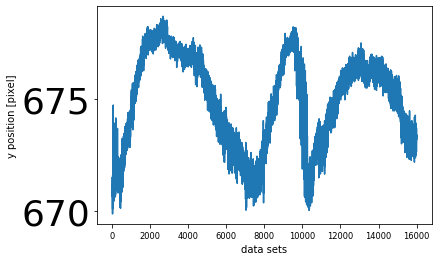

In [16]:
x=np.arange(0,len(H[1]),1)
plt.plot(x,np.multiply(H[1],1))
plt.ylabel("y position [pixel]")
plt.xlabel("data sets")
plt.savefig("Results/Einstein/y_shaking3_20200218.png", dpi=300, bbox_inches ="tight" )
plt.show()

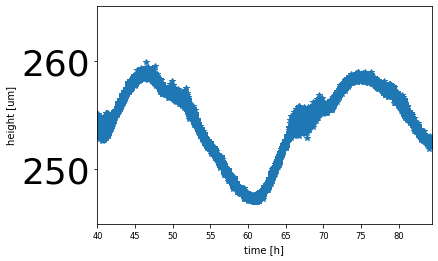

In [17]:
x = np.arange(0,len(H_tot)*10,10)/3600
plt.plot(x,1024*0.46-np.multiply(H_tot,0.46),linestyle="",marker="*")
plt.xlim(x[-16000],x[-1])
plt.ylim(245,265)
plt.ylabel("height [um]")
plt.xlabel("time [h]")
plt.show()

In [18]:
H_list_ns = []
dirnames = ["/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_4/","/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_5/","/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_6/"]
[H_list_ns.append(height_analysis_wrapper(dirname,"Shaking")[0]) for dirname in dirnames]

  0%|          | 0/4952 [00:00<?, ?it/s]

Time passed 216


  0%|          | 0/8600 [00:00<?, ?it/s]

Time passed 525


100%|██████████| 8600/8600 [13:40<00:00, 10.48it/s]

Time passed 820


[None, None, None]

In [19]:
H_list_ns[2] = H_list_ns[2][0]

In [20]:
unix_times_ns = [1581961384.3974102,1581982431.692155,1581982596.0876503,1582034675.2446127,1582045675.098516,1582048163.086894
,1582085941.1935346]

dt_ns = unix_times_ns[2]-unix_times_ns[1]
gap_time_ns = np.zeros(int(dt_ns/10))
gap_time_ns2 =  np.zeros(int((unix_times_ns[5]-unix_times_ns[3])/10))
H_tot_ns = H_list_ns[0]+list(gap_time_ns)+H_list_ns[1]+list(gap_time_ns2)+H_list_ns[2]

TypeError: can only concatenate list (not "float") to list

In [ ]:
x = np.arange(0,len(H_tot_ns)*10,10)/3600
plt.plot(x,1024*0.46-np.multiply(H_tot_ns,0.46),linestyle="",marker="*")
plt.ylim(230,265)
plt.ylabel("height [um]")
plt.xlabel("time [h]")

In [ ]:
dt_between = unix_times_ns[0]-unix_times[-1]
gap_between_sh_and_ns = np.zeros(int(dt_between/10))

In [ ]:
H_all_in_all = H_tot + list(gap_between_sh_and_ns) + H_tot_ns 

In [ ]:
x = np.arange(0,len(H_all_in_all)*10,10)/3600
plt.plot(x,1024*0.46-np.multiply(H_all_in_all,0.46),linestyle="",marker="*")
plt.ylim(230,265)
plt.ylabel("height [um]")
plt.xlabel("time [h]")
plt.axvline(-1,label="lowered bead via z_set_pos",linestyle="dashed", color = "r")
plt.axvline(85,label="retracted shield and attractor",linestyle="dashed", color = "black")
plt.axvline(108,label="shield in, but no attractor",linestyle="dashed",color="green")
plt.legend()
plt.savefig("Results/Einstein/einstein_shaking_up_to_5_20200218.png", dpi=300, bbox_inches ="tight" )
plt.show()

In [ ]:
plt.plot(1024*0.46-np.multiply(pos,0.46))
plt.plot(1024*0.46-np.multiply(pos3,0.46))

#plt.plot(pos2)

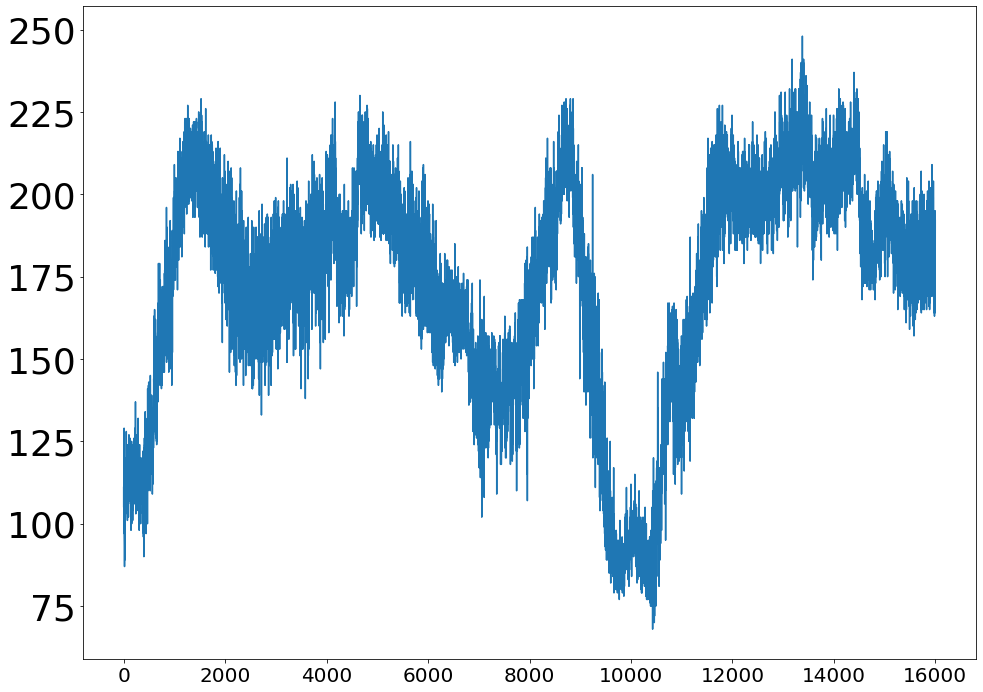

In [164]:
plt.plot(maxi)

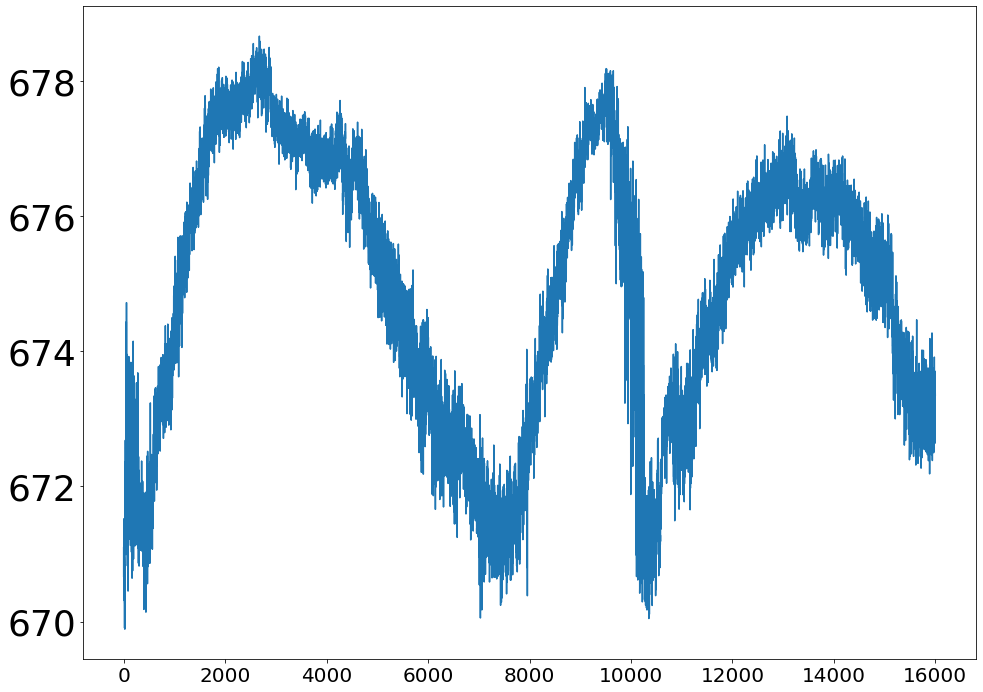

In [161]:
plt.plot(pos2)

(245, 270)

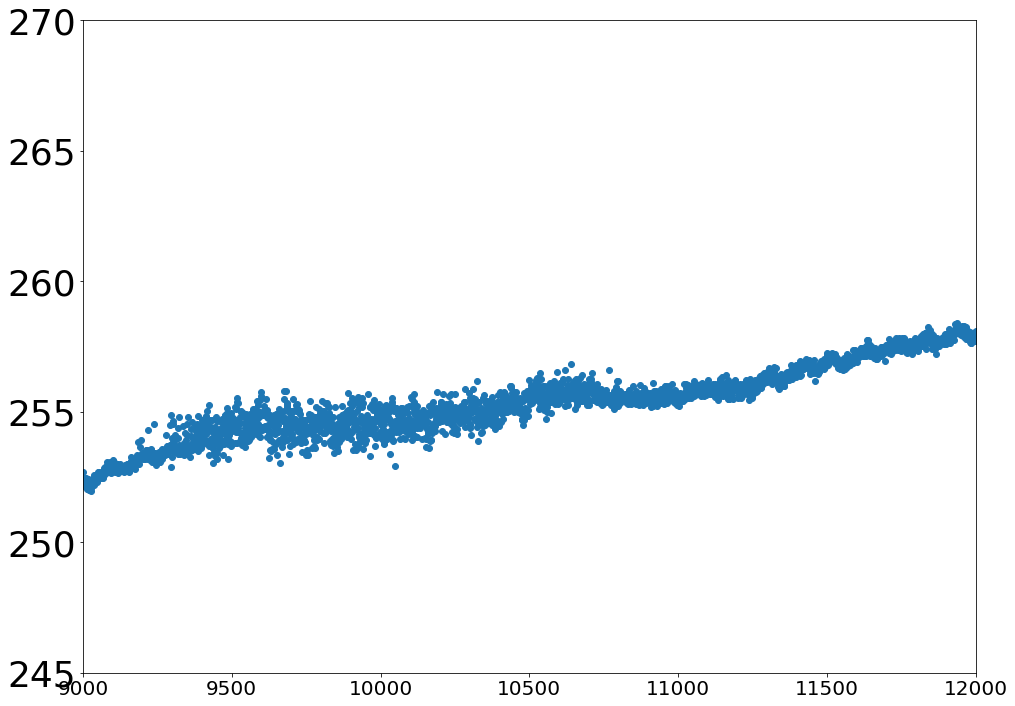

In [117]:
plt.plot(np.subtract(0.46*1024,np.multiply(0.46,pos)),linestyle="",marker="o")
plt.xlim(9000,12000)
plt.ylim(245,270)

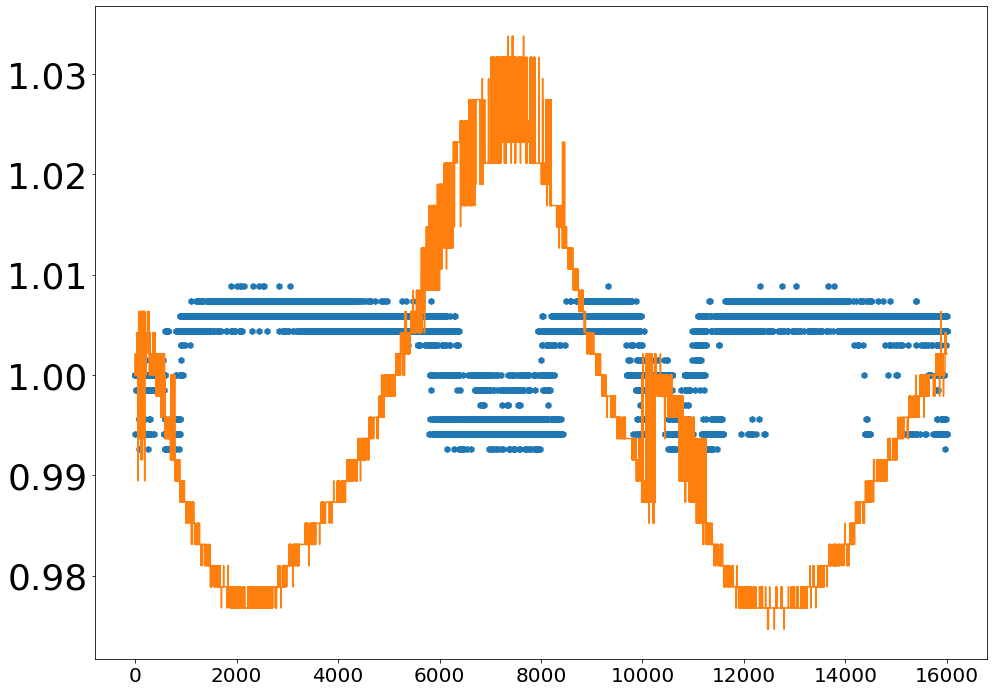

In [143]:
plt.plot(max_zoom/max_zoom[0], linestyle = "", marker ="h")
plt.plot(max_zoom2/max_zoom2[0])

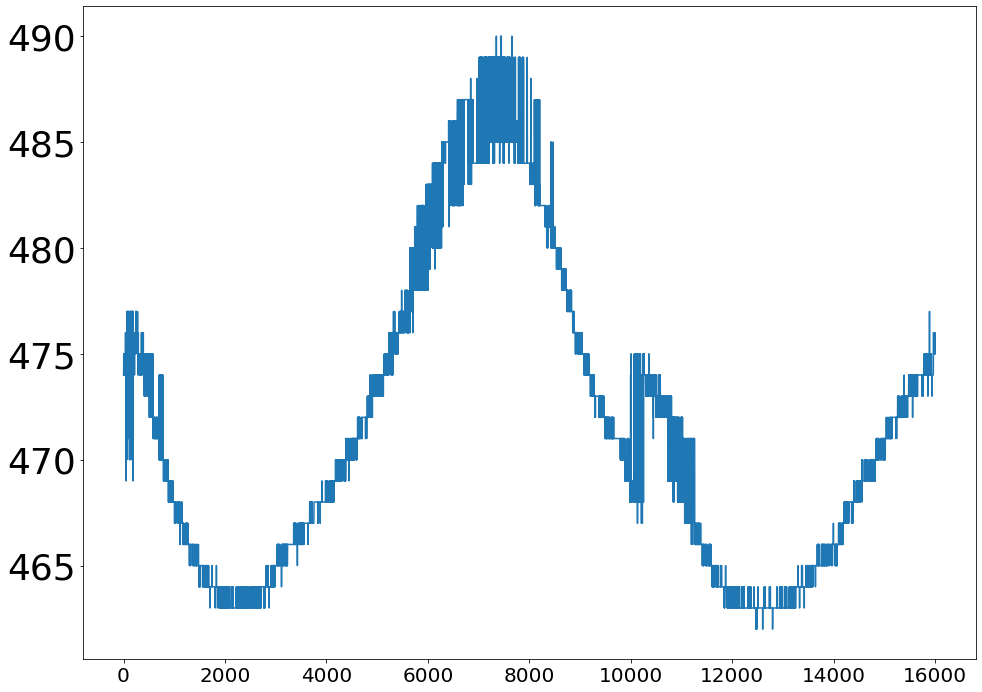

In [148]:
#plt.plot(max_zoom, linestyle = "", marker ="h")
plt.plot(max_zoom2)

In [6]:
bmp_images_transposed=[]
bmp_images = load_img_files("/data/new_trap/20200210/Bead2/Height_Investigation_Einstein_20200217/*bmp")
[bmp_images_transposed.append(elements.transpose()) for elements in bmp_images]
comparison_image = np.load("/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_4/Shaking0.npy")
comparison_image_transposed = comparison_image.transpose()

['/data/new_trap/20200210/Bead2/Height_Investigation_Einstein_20200217/shield_illumination_before_retraction.bmp', '/data/new_trap/20200210/Bead2/Height_Investigation_Einstein_20200217/attractor_out_shield_illu_before_retraction.bmp', '/data/new_trap/20200210/Bead2/Height_Investigation_Einstein_20200217/shield_illu_after_moving_back_to_75V.bmp', '/data/new_trap/20200210/Bead2/Height_Investigation_Einstein_20200217/no_shield_illumination_before_retraction.bmp']


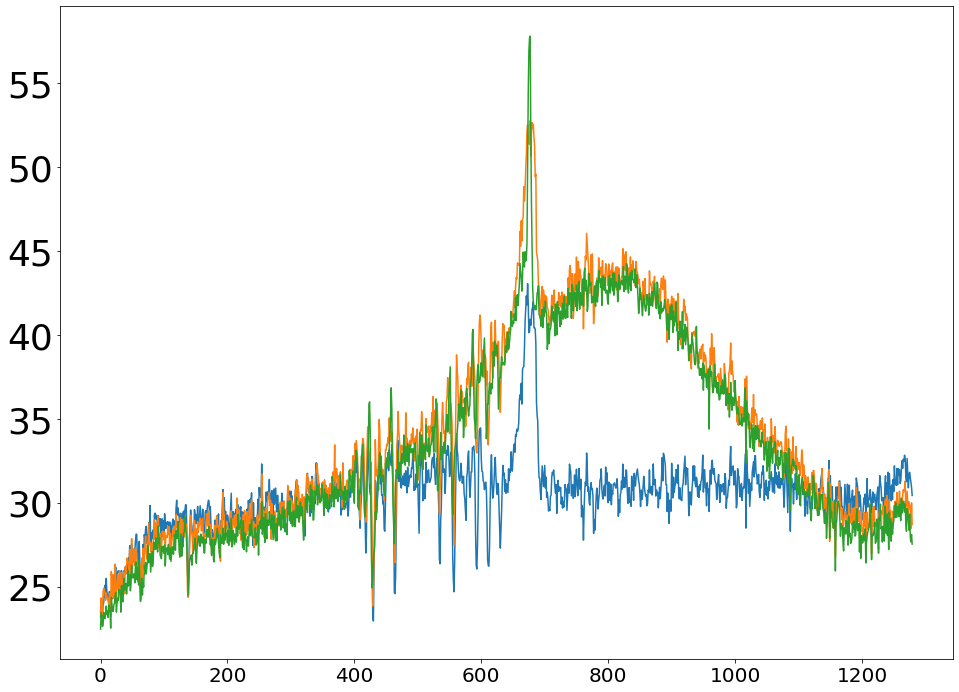

In [187]:
plt.plot(np.mean(bmp_images[0][420:550],axis=0))
plt.plot(np.mean(bmp_images[1][420:550],axis=0))
plt.plot(np.mean(bmp_images[2][420:550],axis=0))


(400, 600)

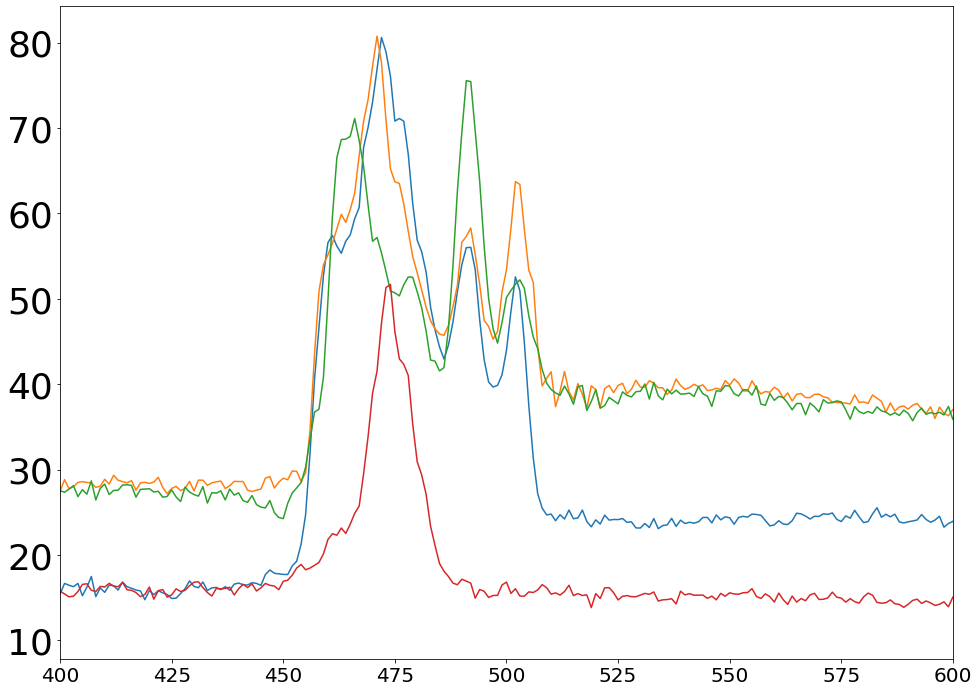

In [190]:
plt.plot(np.mean(bmp_images_transposed[0][610:700],axis=0))
plt.plot(np.mean(bmp_images_transposed[1][610:700],axis=0))
plt.plot(np.mean(bmp_images_transposed[2][610:700],axis=0))

plt.xlim(400,600)

(500, 750)

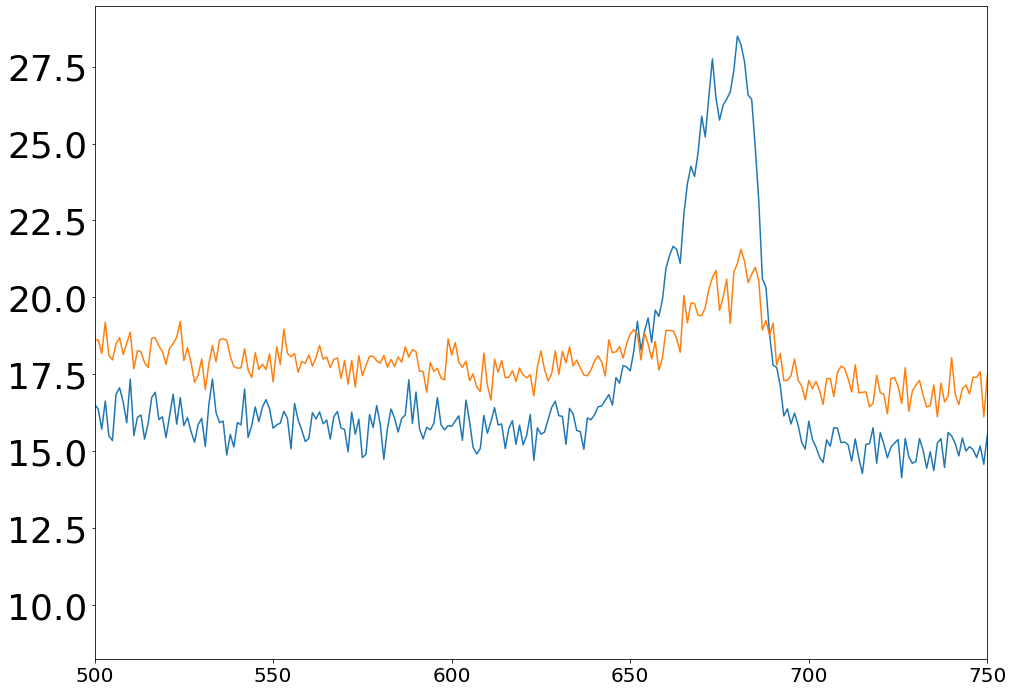

In [23]:
plt.plot(np.mean(bmp_images[3][420:550],axis=0))
plt.plot(np.mean(comparison_image[420:550],axis=0))
plt.xlim(500,750)


(400, 600)

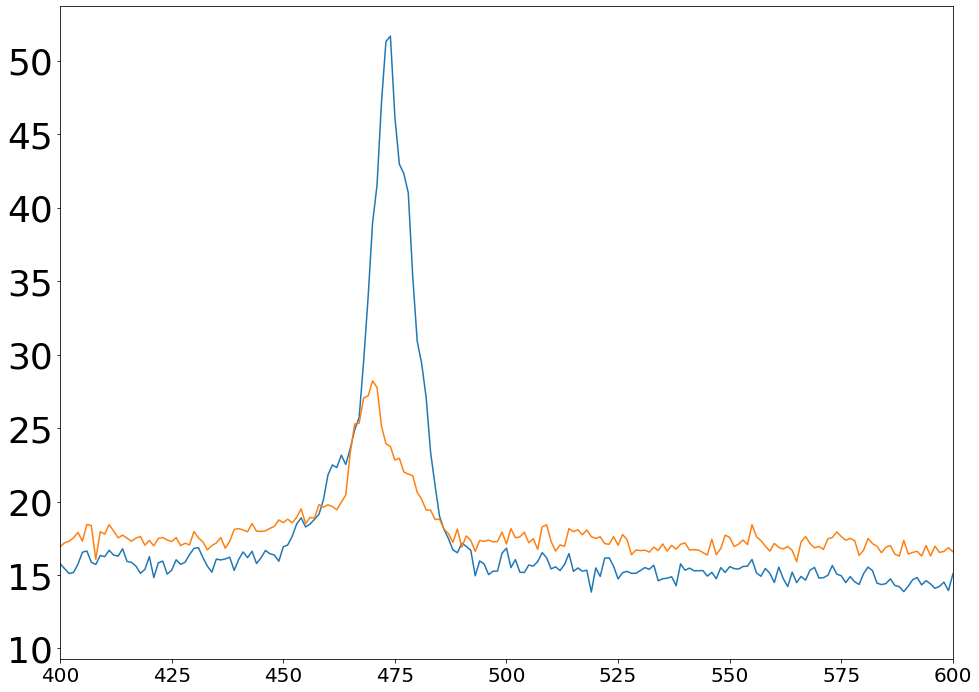

In [17]:
plt.plot(np.mean(bmp_images_transposed[3][610:700],axis=0))
plt.plot(np.mean(comparison_image_transposed[610:700],axis=0))
plt.xlim(400,600)


In [25]:
print(gaussian_bead_pos_fit(bmp_images[3]))
print(gaussian_bead_pos_fit(comparison_image))

673.7214262382918
671.4445701164342


In [31]:
print(gaussian_bead_pos_fit(bmp_images[3],axis=0))
print(gaussian_bead_pos_fit(comparison_image,axis=0))

473.59244301908075
467.6966683568173


In [32]:
np.max(bmp_images[3])

201

In [33]:
np.max(comparison_image)

88

In [116]:
image1=np.load("/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_3/Shaking2100.npy")
image2=np.load("/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_3/Shaking7000.npy")

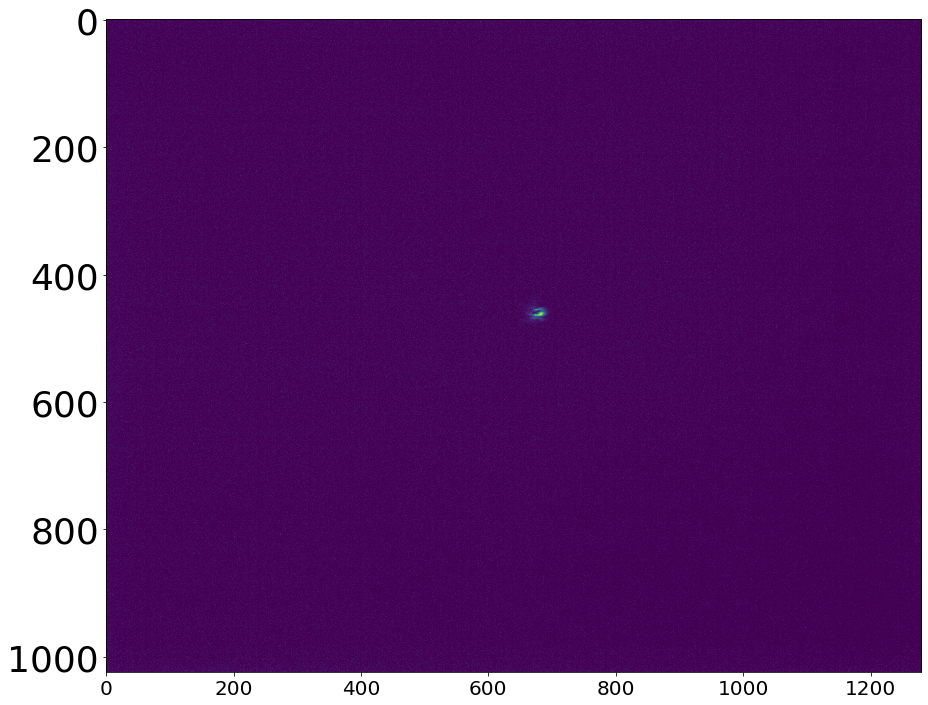

In [117]:
plt.imshow(image1)

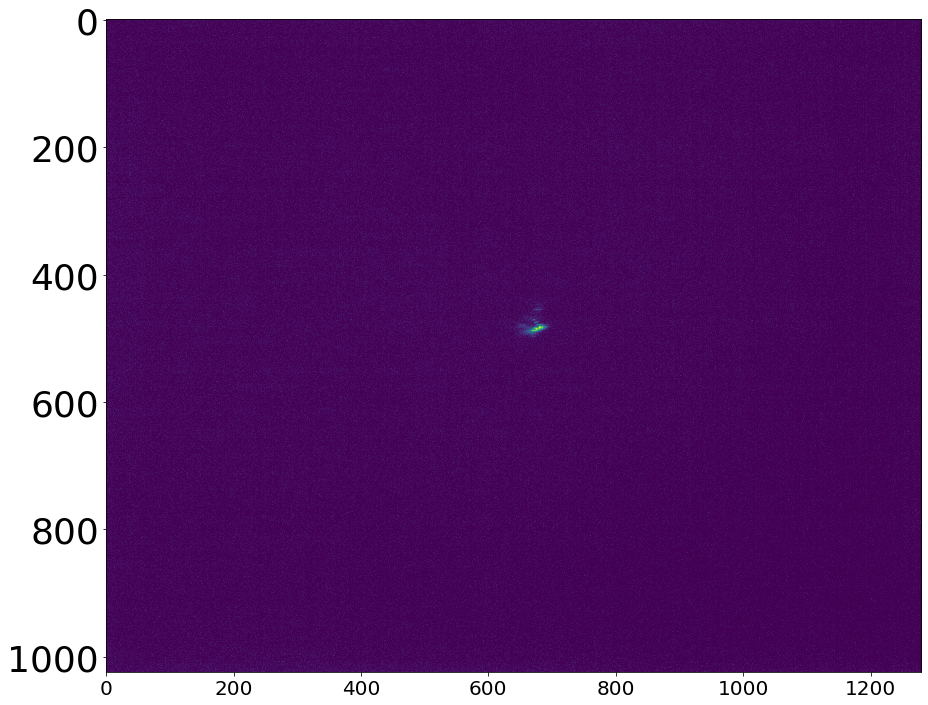

In [118]:
plt.imshow(image2)

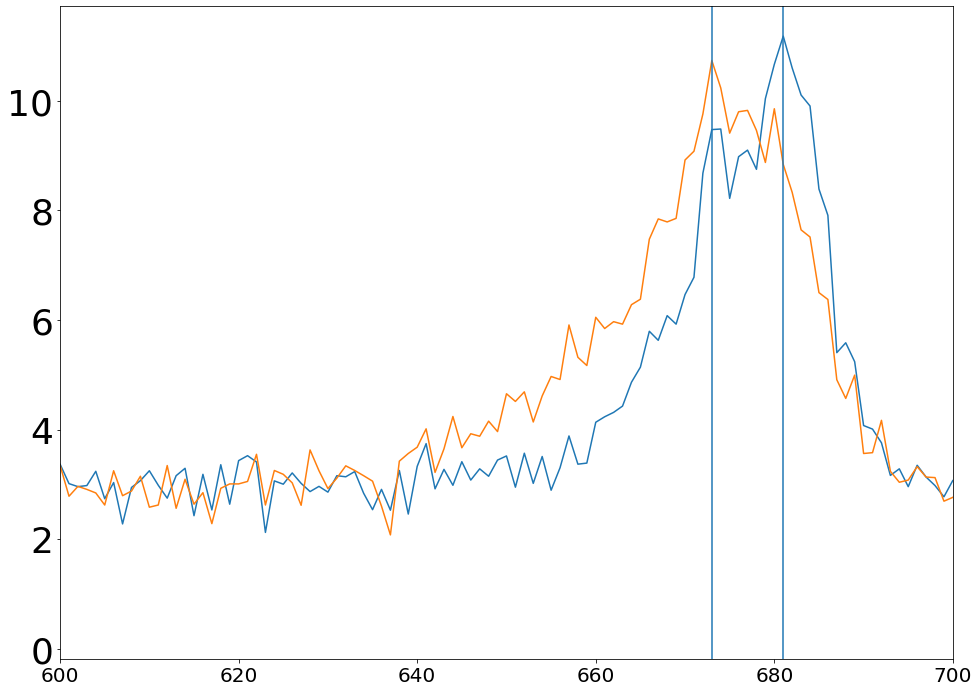

In [126]:
plt.plot(np.mean(image1[400:600],axis=0))
plt.plot(np.mean(image2[400:600],axis=0))
plt.xlim(600,700)
plt.axvline(673)
plt.axvline(681)

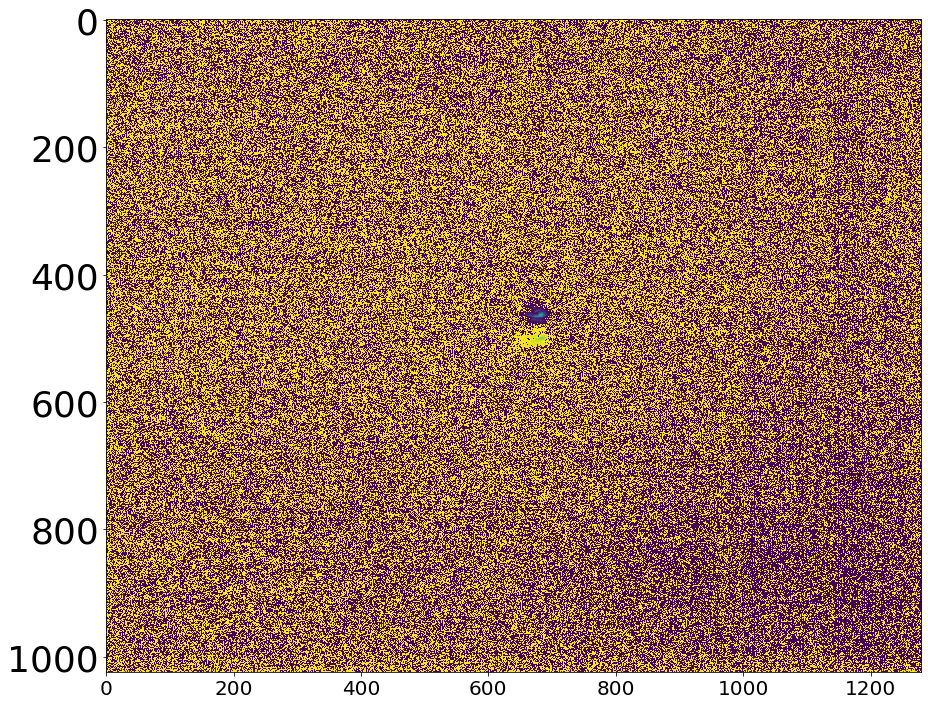

In [97]:
plt.imshow(image1-image2)